# Telecom Churn Project

### Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, **telecom companies need to predict which customers are at high risk of churn.**

### Models with their accuracy, sensitivity and specificity

No | Algorithm | Accuracy Score |  AUC Score | ROC_AUC Score | Non-Churn Accuracy Rate(Specificity) | Churn Accuracy Rate (Sensitivity) |
-|----------|----------------|------------|---------------|-------------------------|---------------------|
1|Basic Logistic Regression | 0.92 | 0.73 | 0.91 | 0.97 | 0.48 |
2|Logistic Regression with PCA | 0.91 | 0.61 | 0.89 | 0.98 | 0.24 |
3|Random Forest with Hyperparameter tuning | 0.93 | 0.70 | 0.93 | 0.98 | 0.42 |  
4|Using SMOTE and Logistic Regression | 0.87 | 0.84 | 0.92 | 0.88 | 0.80 |
5|<b><font color='#00cccc'>Using SMOTE and Random Forest </font></b> | 0.90 | 0.84 | <b><font color='#00FF00'>0.92 </font></b>| 0.91 | <b><font color='#FF0000'>0.77 </font></b>|
6|<b><font color='#00cccc'>Using SMOTE and Logisitic Regression with PCA </font></b> | 0.82 | 0.82 | <b><font color='#00FF00'>0.90</font></b> | 0.82 | <b><font color='#00FF00'>0.83 </font></b> | 
7|<b><font color='#00cccc'>Using SMOTE and Decision Trees </font></b> | 0.83 | 0.81 | <b><font color='#00FF00'>0.87</font></b> | 0.84 | <b><font color='#FF0000'>0.78 </font></b> | 

#### Best model describing in predicting churn accuracy(Sensitivity) is Using Logisitic Regression with PCA & SMOTE for class imbalance

##### Importing common Libraries 

In [152]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Common Functions used in the notebook

In [156]:
def EDA():
    column_Month_6=tele.filter(like='6').columns
    for count, eachFeature in enumerate(column_Month_6):
        col = eachFeature
        X1 = tele.groupby(['churn'])[col].agg(['mean']).reset_index()
        X1.rename(columns={'mean': "mean_"+col}, inplace=True)
        if(col == 'jun_vbc_3g'):
            col = 'jul_vbc_3g'
        else:
            col = col[:-1] + "7"
        X2 = tele.groupby(['churn'])[col].agg(['mean']).reset_index()
        X2.rename(columns={'mean': "mean_"+col}, inplace=True)
        if(col == 'jul_vbc_3g'):
            col = 'aug_vbc_3g'
        else:
            col = col[:-1] + "8"
        X3 = tele.groupby(['churn'])[col].agg(['mean']).reset_index()
        X3.rename(columns={'mean': "mean_"+col}, inplace=True)

        X1 = pd.merge(X1, X2, on = ['churn'])
        X1 = pd.merge(X1,X3, on = ['churn'])
        X1.head()
        X1 = X1.transpose().reset_index()
        X1 = X1.loc[1:]
        X1.columns = ['Feature', 'Not-Churn', 'Churn']
        #X1.head()
        X1['Usage%_During_Churn'] = round((X1['Churn']/(X1['Not-Churn'] + X1['Churn']))*100,2)
        print(X1.head())
        plt.figure(figsize=(12, 6))
        ax = plt.subplot(111)
        p = sns.barplot(x='Feature', y='Usage%_During_Churn', data=X1)
        p.set_xticklabels(p.get_xticklabels(),rotation=45)
        plt.title('Churn subscriber usage to Total Usage % for {}'.format(col[:-2]), fontsize = 12)
        X1.rename(columns={'Usage%_During_Churn':'Churn_Subscriber_Usage_Trend'}, inplace=True)
        plt.plot(X1['Churn_Subscriber_Usage_Trend'], 'r-')
        #plt.title(title, fontsize = 12)
        ax.legend(loc='upper center', bbox_to_anchor=(0.8, 1.00), shadow=True, ncol=2, fontsize = 10)
        plt.grid(True)
        plt.show()
        
        
# Method to draw AUC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return fpr, tpr, thresholds


# Common Function to Do the Model Evalution
def modelEvaluation(y_test, y_pred, model, flag = 0):
    print(confusion_matrix(y_test,y_pred))
    print("Accuracy Score ==> {}".format(accuracy_score(y_test,y_pred)))
    print("AUC Score ==> {}".format(roc_auc_score(y_test,y_pred)))
    if flag == 1: #For PCA
        pred_probs_test = model.predict_proba(X_test_pca)[:,1]
    else:
        pred_probs_test = model.predict_proba(X_test)[:,1]
    print("ROC_AUC Score ==> {:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test)))
    TP = (confusion_matrix(y_test,y_pred))[0][0]
    FP = (confusion_matrix(y_test,y_pred))[0][1]
    FN = (confusion_matrix(y_test,y_pred))[1][0]
    TN = (confusion_matrix(y_test,y_pred))[1][1]
    print("Not-Churn Accuracy Rate:(Specificity) ==> {}".format(TP/(TP+FP)))
    print("Churn Accuracy Rate:(Sensitivity) ==> {}".format(TN/(TN+FN)))
    draw_roc(y_test, y_pred)

In [158]:
tele=pd.read_csv('telecom_churn_data.csv')
tele.head()
print(tele.shape)

(99999, 226)


In [160]:
tele.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [162]:
tele.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.505000   
25%               0.0     93.411500     86.980500     84.126000     62.685000   
50%               0.0    197.704000    191.640000    192.080000    176.849000   
75%               0.0    371.060000    365.344500    369.370500    353.466500   
max               0.0  27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6   onnet_mou_7   onnet_mou_8   onnet_mou_9  offnet_mou_6  \
count  96062.000000  96140.000000  94621.000000  92254.000000  96062.000000   
mean     132.395875    133.670805    133.018098    130.302327    197.935577   
std      297.207406    308.794148    308.951589    308.477668    316.851613   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.380000      6.660000      6.460000      5.330000     34.730000   
50%       34.310000     32.330000     32.360000     29.840000     96.310000   
75%      118.740000    115.595000    115.860000    112.130000    231.860000   
max     7376.710000   8157.780000  10752.560000  10427.460000   8362.360000   

       offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count  96140.000000  94621.000000  92254.000000   96062.000000   96140.000000   
mean     197.045133    196.574803    190.337222       9.950013       7.149898   
std      325.862803    327.170662    319.396092      72.825411      73.447948   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%       32.190000     31.630000     27.130000       0.000000       0.000000   
50%       91.735000     92.140000     87.290000       0.000000       0.000000   
75%      226.815000    228.260000    220.505000       0.000000       0.000000   
max     9667.130000  14007.340000  10310.760000   13724.380000   15371.040000   

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count   94621.000000   92254.000000   96062.000000   96140.000000   
mean        7.292981       6.343841      13.911337       9.818732   
std        68.402466      57.137537      71.443196      58.455762   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max     13095.360000    8464.030000    3775.110000    2812.040000   

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   94621.000000   92254.000000      96062.000000      96140.000000   
mean        9.971890       8.555519         47.100763         46.473010   
std        64.713221      58.438186        150.856393        155.318705   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.630000   
50%         0.000000       0.000000         11.910000         11.610000   
75%         0.000000       0.000000         40.960000         39.910000   
max      

In [164]:
tele.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

### Filtering High Valued Customers

In [166]:
tele['last_2month_rech']=tele['total_rech_amt_6']+tele['total_rech_amt_7']
high_prof_avg=int(tele['last_2month_rech'].quantile(0.70))
tele=tele.loc[(tele.last_2month_rech>high_prof_avg)]
print('Total High valued customers are',tele.shape[0])
tele.drop(['last_2month_rech'],axis=1,inplace=True)

Total High valued customers are 29979


#### Checking for null values and percentages in columns( >50%)

In [168]:
na_v=tele.isnull().sum()*100/(tele.shape[0])
na_col=na_v[na_v.values>50]
print('Columns containing more than 50% Null values are :',str(na_col.index))
tele.drop(list(na_col.index),axis=1,inplace=True)
tele.shape

Columns containing more than 50% Null values are : Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6',
       'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8', 'av_rech_amt_data_9', 'arpu_3g_6', 'arpu_3g_7',
       'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
       'arpu_2g_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
       'night_pck_user_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9'],
      dtype='object')


(29979, 186)

In [170]:
na_v=tele.isnull().sum()*100/(tele.shape[0])
na_col_lessthan_50=na_v[na_v.values<=50]
print('Columns containing less than 50% Null values are :',na_col_lessthan_50)

Columns containing less than 50% Null values are : mobile_number           0.000000
circle_id               0.000000
loc_og_t2o_mou          0.380266
std_og_t2o_mou          0.380266
loc_ic_t2o_mou          0.380266
last_date_of_month_6    0.000000
last_date_of_month_7    0.103406
last_date_of_month_8    0.523700
last_date_of_month_9    1.200841
arpu_6                  0.000000
arpu_7                  0.000000
arpu_8                  0.000000
arpu_9                  0.000000
onnet_mou_6             1.054071
onnet_mou_7             1.010707
onnet_mou_8             3.128857
onnet_mou_9             5.680643
offnet_mou_6            1.054071
offnet_mou_7            1.010707
offnet_mou_8            3.128857
offnet_mou_9            5.680643
roam_ic_mou_6           1.054071
roam_ic_mou_7           1.010707
roam_ic_mou_8           3.128857
roam_ic_mou_9           5.680643
roam_og_mou_6           1.054071
roam_og_mou_7           1.010707
roam_og_mou_8           3.128857
roam_og_mou_9           5

#### Checking columns with just one unique value and dropping it

In [172]:
uni=[]
print('Columns with one unique value:')
for x in tele.columns:
    if tele[x].nunique()==1:
        uni.append(x)
        print(x)
# as we will be needing last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9 later on, we wont be
#removing it
for i in range(4):
    del uni[4]
tele=tele.drop(uni,axis=1)
tele['last_date_of_month_6'] = tele['last_date_of_month_6'].fillna('6/30/2014')
tele['last_date_of_month_7'] = tele['last_date_of_month_7'].fillna('7/31/2014')
tele['last_date_of_month_8'] = tele['last_date_of_month_8'].fillna('8/31/2014')
tele['last_date_of_month_9'] = tele['last_date_of_month_9'].fillna('9/30/2014')
tele.shape

Columns with one unique value:
circle_id
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
last_date_of_month_9
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_t2c_mou_9
std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8
std_ic_t2o_mou_9


(29979, 174)

In [174]:
# changing dates column to datetime format
dates=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9','last_date_of_month_7','last_date_of_month_6','last_date_of_month_8','last_date_of_month_9']
tele[dates]=tele[dates].apply(pd.to_datetime)

#### Calculating recharge recency in number of days for analysis. Imputing max 30days for NA values as no recharge is done.

In [176]:
tele['rech_recency_6']=(max(tele['last_date_of_month_6'])-tele.date_of_last_rech_6).dt.days
tele['rech_recency_7']=(max(tele['last_date_of_month_7'])-tele.date_of_last_rech_7).dt.days
tele['rech_recency_8']=(max(tele['last_date_of_month_8'])-tele.date_of_last_rech_8).dt.days
tele['rech_recency_9']=(max(tele['last_date_of_month_9'])-tele.date_of_last_rech_9).dt.days

tele['rech_recency_6']= tele['rech_recency_6'].fillna(30)
tele['rech_recency_7'] = tele['rech_recency_7'].fillna(30)
tele['rech_recency_8'] = tele['rech_recency_8'].fillna(30)
tele['rech_recency_9'] =tele['rech_recency_9'].fillna(30)
tele.head()

mobile_number last_date_of_month_6 last_date_of_month_7  \
7      7000701601           2014-06-30           2014-07-31   
8      7001524846           2014-06-30           2014-07-31   
13     7002191713           2014-06-30           2014-07-31   
16     7000875565           2014-06-30           2014-07-31   
17     7000187447           2014-06-30           2014-07-31   

   last_date_of_month_8 last_date_of_month_9    arpu_6    arpu_7    arpu_8  \
7            2014-08-31           2014-09-30  1069.180  1349.850  3171.480   
8            2014-08-31           2014-09-30   378.721   492.223   137.362   
13           2014-08-31           2014-09-30   492.846   205.671   593.260   
16           2014-08-31           2014-09-30   430.975   299.869   187.894   
17           2014-08-31           2014-09-30   690.008    18.980    25.499   

     arpu_9  onnet_mou_6  onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  \
7   500.000        57.84        54.68        52.29          NaN        453.43   
8   166.787       413.69       351.03        35.08        33.46         94.66   
13  322.732       501.76       108.39       534.24       244.81        413.31   
16  206.490        50.51        74.01        70.61        31.34        296.29   
17  257.583      1185.91         9.28         7.79       558.51         61.64   

    offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
7         567.16        325.91           NaN          16.23          33.49   
8          80.63        136.48        108.71           0.00           0.00   
13        119.28        482.46        214.06          23.53         144.24   
16        229.74        162.76        224.39           0.00           2.83   
17          0.00          5.54         87.89           0.00           4.76   

    roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
7           31.64            NaN          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00           0.00   
13          72.11         136.78           7.98          35.26           1.44   
16           0.00           0.00           0.00          17.74           0.00   
17           4.81           0.00           0.00           8.46          13.34   

    roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
7             NaN             51.39             31.38             40.28   
8            0.00            297.13            217.59             12.49   
13          12.78             49.63              6.19             36.01   
16           0.00             42.61             65.16             67.38   
17          17.98             38.99              0.00              0.00   

    loc_og_t2t_mou_9  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
7                NaN            308.63            447.38            162.28   
8              26.13             80.96             70.58             50.54   
13              6.14            151.13             47.28            294.46   
16             26.88            273.29            145.99            128.28   
17             36.41             58.54              0.00              0.00   

    loc_og_t2m_mou_9  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
7                NaN             62.13             55.14             53.23   
8              34.58              0.00              0.00              0.00   
13            108.24              4.54              0.00             23.51   
16            201.49              0.00              4.48             10.26   
17              9.38              0.00              0.00              0.00   

    loc_og_t2f_mou_9  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
7                NaN               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
13              5.29               0.0               0.0              0.49   
16          

#### As dates columns are no more required for analysis. Drop them

In [178]:
col_dates = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8','last_date_of_month_9',
              'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9']
tele.drop(col_dates,axis=1,inplace=True)
tele.shape

(29979, 170)

### Imputing 0 values in columns for NA
#### 1. As we have seen above, subscribers with less than 50% null values are very less percentage of around 1% or 2%. 
#### 2. As subscribers may not have used any special call or isd calls for considerate MOU

In [180]:
#### Columns with less than 50% NULL values are:
na_v=tele.isnull().sum()*100/(tele.shape[0])
na_col_lessthan_50=na_v[na_v.values<=50]
print('Columns containing less than 50% Null values are :',na_col_lessthan_50)

Columns containing less than 50% Null values are : mobile_number         0.000000
arpu_6                0.000000
arpu_7                0.000000
arpu_8                0.000000
arpu_9                0.000000
onnet_mou_6           1.054071
onnet_mou_7           1.010707
onnet_mou_8           3.128857
onnet_mou_9           5.680643
offnet_mou_6          1.054071
offnet_mou_7          1.010707
offnet_mou_8          3.128857
offnet_mou_9          5.680643
roam_ic_mou_6         1.054071
roam_ic_mou_7         1.010707
roam_ic_mou_8         3.128857
roam_ic_mou_9         5.680643
roam_og_mou_6         1.054071
roam_og_mou_7         1.010707
roam_og_mou_8         3.128857
roam_og_mou_9         5.680643
loc_og_t2t_mou_6      1.054071
loc_og_t2t_mou_7      1.010707
loc_og_t2t_mou_8      3.128857
loc_og_t2t_mou_9      5.680643
loc_og_t2m_mou_6      1.054071
loc_og_t2m_mou_7      1.010707
loc_og_t2m_mou_8      3.128857
loc_og_t2m_mou_9      5.680643
loc_og_t2f_mou_6      1.054071
loc_og_t2f_mou_7   

In [184]:
tele=tele.fillna(0)

In [185]:
na=tele.isnull().sum()*100/(tele.shape[0])
na_col=na[(na.values)>0]
print('Columns containing greater than 0% Null values are :',na_col)

Columns containing greater than 0% Null values are : Series([], dtype: float64)


In [186]:
tele.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 170 entries, mobile_number to rech_recency_9
dtypes: float64(136), int64(34)
memory usage: 39.1 MB


### Labeling churn/ non-churn customers

In [190]:
tele['churn'] = np.where(
            (
                (tele['total_ic_mou_9'] == 0.0) | 
                (tele['total_og_mou_9'] == 0.0)
            ) & 
            (
                (tele['vol_2g_mb_9'] == 0.0) & 
                (tele['vol_3g_mb_9'] == 0.0)
            ),1,0
        )

KeyError: 'total_ic_mou_9'

#### Dropping columns with 9 month phase

In [188]:
tele = tele.drop(tele.filter(like = '9').columns, axis=1)

In [191]:
tele.churn.value_counts()*100/tele.shape[0]

0    90.359919
1     9.640081
Name: churn, dtype: float64

#### As we can see its imbalanced dataset with only 9.6% churned customers

### Derived metrics
#### 1.We can find total incoming to outgoing calls ratio
#### 2.Avg. Recharge amount= Total rech. amount/ total number of rech.
#### 3.
- As we know total_og_mou_6 = loc_og_mou_6+  std_og_mou_6 + spl_og_mou_6 + og_others_6
- We can find percentage of loc_og_mou_6*100 /total_og_mou_6 in addition to all other components of 6th month. We can do same for all others months

In [192]:
tele['i_og_avg']=round((tele['total_ic_mou_6']+tele['total_ic_mou_7']+tele['total_ic_mou_8'])/(tele['total_og_mou_6']+tele['total_og_mou_7']+tele['total_og_mou_8']),5)
tele['rech_avg_6']=round(tele['total_rech_amt_6']/tele['total_rech_num_6'],2)
tele['rech_avg_7']=round(tele['total_rech_amt_7']/tele['total_rech_num_7'],2)
tele['rech_avg_8']=round(tele['total_rech_amt_8']/tele['total_rech_num_8'],2)

tele['loc_og_mou_Percent_6'] = round((tele['loc_og_mou_6']/tele['total_og_mou_6']) * 100,2)
tele['std_og_mou_Percent_6'] = round((tele['std_og_mou_6']/tele['total_og_mou_6']) * 100,2)
tele['spl_og_mou_Percent_6'] = round((tele['spl_og_mou_6']/tele['total_og_mou_6']) * 100,2)
tele['og_others_Percent_6'] = round((tele['og_others_6']/tele['total_og_mou_6']) * 100,2)
tele['loc_ic_mou_Percent_6'] = round((tele['loc_ic_mou_6']/tele['total_ic_mou_6']) * 100,2)
tele['std_ic_mou_Percent_6'] = round((tele['std_ic_mou_6']/tele['total_ic_mou_6']) * 100,2)
tele['spl_ic_mou_Percent_6'] = round((tele['spl_ic_mou_6']/tele['total_ic_mou_6']) * 100,2)
tele['ic_others_Percent_6'] = round((tele['ic_others_6']/tele['total_ic_mou_6']) * 100,2)

tele['loc_og_mou_Percent_7'] = round((tele['loc_og_mou_7']/tele['total_og_mou_7']) * 100,2)
tele['std_og_mou_Percent_7'] = round((tele['std_og_mou_7']/tele['total_og_mou_7']) * 100,2)
tele['spl_og_mou_Percent_7'] = round((tele['spl_og_mou_7']/tele['total_og_mou_7']) * 100,2)
tele['og_others_Percent_7'] = round((tele['og_others_7']/tele['total_og_mou_7']) * 100,2)
tele['loc_ic_mou_Percent_7'] = round((tele['loc_ic_mou_7']/tele['total_ic_mou_7']) * 100,2)
tele['std_ic_mou_Percent_7'] = round((tele['std_ic_mou_7']/tele['total_ic_mou_7']) * 100,2)
tele['spl_ic_mou_Percent_7'] = round((tele['spl_ic_mou_7']/tele['total_ic_mou_7']) * 100,2)
tele['ic_others_Percent_7'] = round((tele['ic_others_7']/tele['total_ic_mou_7']) * 100,2)

tele['loc_og_mou_Percent_8'] = round((tele['loc_og_mou_8']/tele['total_og_mou_8']) * 100,2)
tele['std_og_mou_Percent_8'] = round((tele['std_og_mou_8']/tele['total_og_mou_8']) * 100,2)
tele['spl_og_mou_Percent_8'] = round((tele['spl_og_mou_8']/tele['total_og_mou_8']) * 100,2)
tele['og_others_Percent_8'] = round((tele['og_others_8']/tele['total_og_mou_8']) * 100,2)
tele['loc_ic_mou_Percent_8'] = round((tele['loc_ic_mou_8']/tele['total_ic_mou_8']) * 100,2)
tele['std_ic_mou_Percent_8'] = round((tele['std_ic_mou_8']/tele['total_ic_mou_8']) * 100,2)
tele['spl_ic_mou_Percent_8'] = round((tele['spl_ic_mou_8']/tele['total_ic_mou_8']) * 100,2)
tele['ic_others_Percent_8'] = round((tele['ic_others_8']/tele['total_ic_mou_8']) * 100,2)

tele=tele.replace(np.inf,0)
tele=tele.fillna(0)

churn     AON_avg
0      0  1306.73683
1      1   865.06090

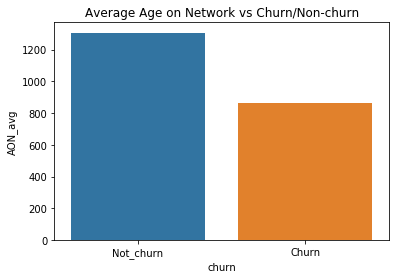

In [193]:
dat=tele.groupby('churn')['aon'].agg(['mean']).reset_index()
dat.columns=['churn','AON_avg']
pt=sns.barplot(x='churn',y='AON_avg',data=dat)
pt.set_xticklabels(['Not_churn','Churn'])
plt.title('Average Age on Network vs Churn/Non-churn')
dat

### Inference: Avg. AON of churned customer is 33% approx less than non-churning.

## EDA

       Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_arpu_6  579.100916  667.136565                53.53
2  mean_arpu_7  594.462373  542.204599                47.70
3  mean_arpu_8  566.533566  240.127416                29.77


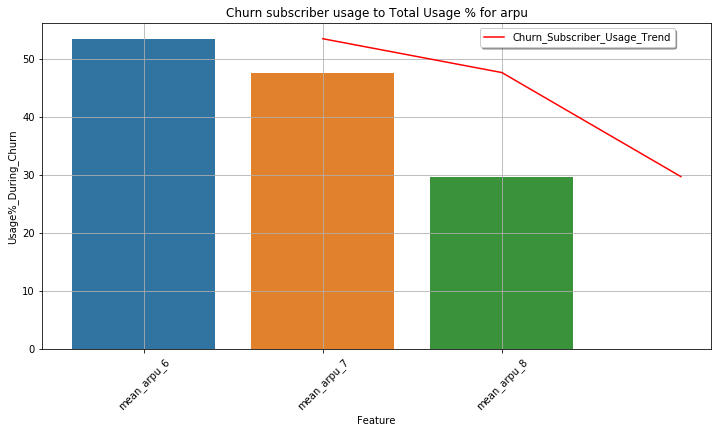

            Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_onnet_mou_6  285.228165  399.419889                58.34
2  mean_onnet_mou_7  303.911379  310.970893                50.57
3  mean_onnet_mou_8  283.675175  119.091218                29.57


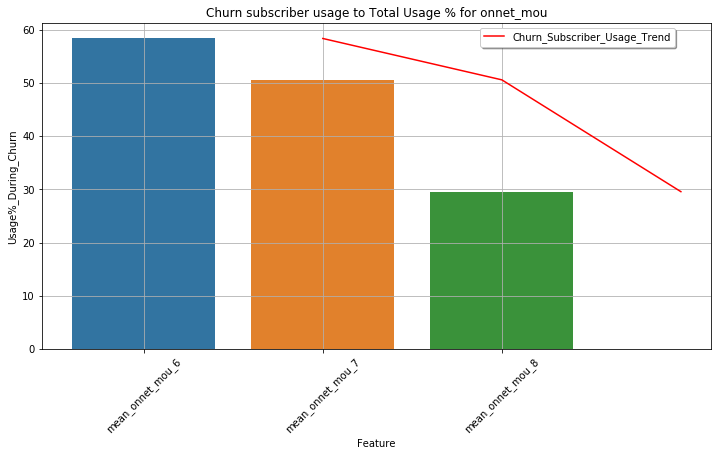

             Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_offnet_mou_6  409.124991  502.513744                55.12
2  mean_offnet_mou_7  426.049209  405.865118                48.79
3  mean_offnet_mou_8  399.125164  150.525215                27.39


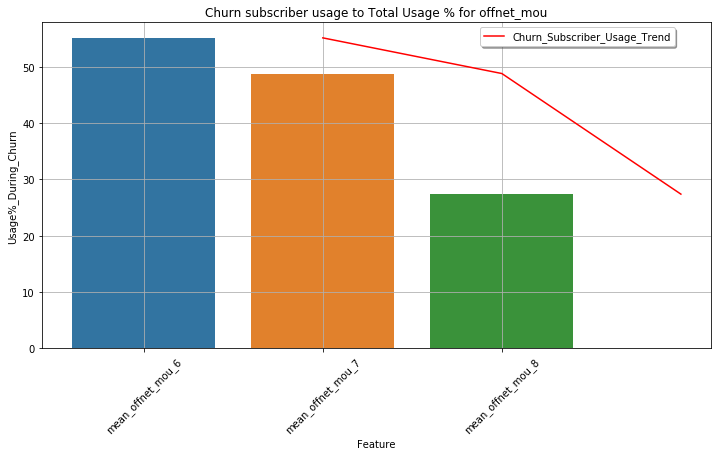

              Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_roam_ic_mou_6  16.236956  28.592834                63.78
2  mean_roam_ic_mou_7  11.936211  28.523813                70.50
3  mean_roam_ic_mou_8  11.918812  25.863318                68.45


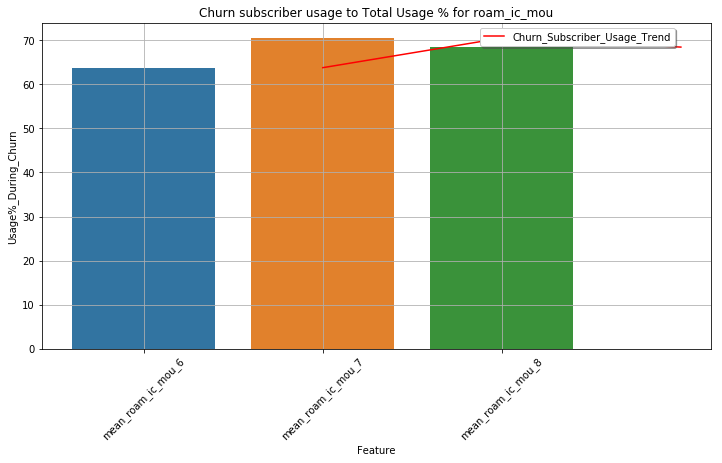

              Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_roam_og_mou_6  26.969581  51.645522                65.69
2  mean_roam_og_mou_7  19.245387  48.405287                71.55
3  mean_roam_og_mou_8  19.164140  43.224118                69.28


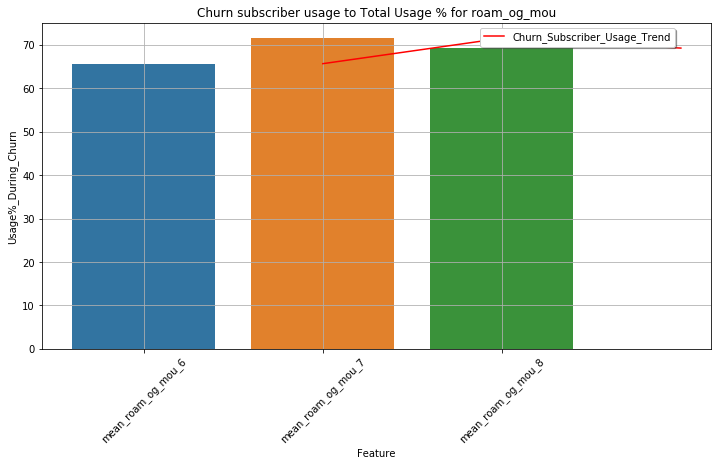

                 Feature   Not-Churn      Churn  Usage%_During_Churn
1  mean_loc_og_t2t_mou_6   97.748689  66.471699                40.48
2  mean_loc_og_t2t_mou_7  100.858115  48.257990                32.36
3  mean_loc_og_t2t_mou_8   94.592089  17.751176                15.80


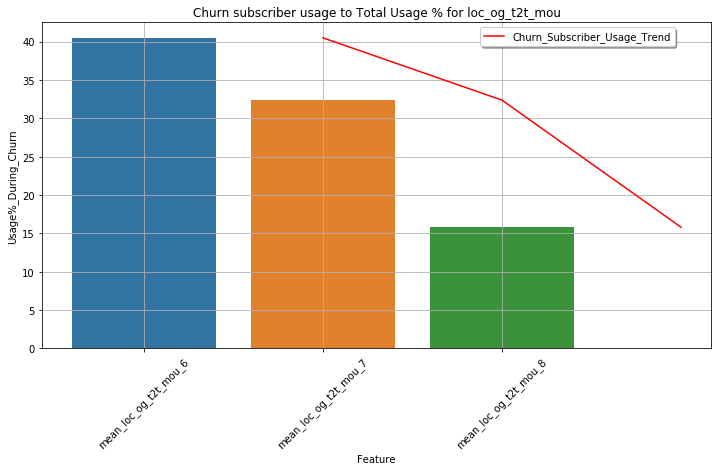

                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_loc_og_t2m_mou_6  187.394050  124.559536                39.93
2  mean_loc_og_t2m_mou_7  190.213292   97.997076                34.00
3  mean_loc_og_t2m_mou_8  181.526483   37.235824                17.02


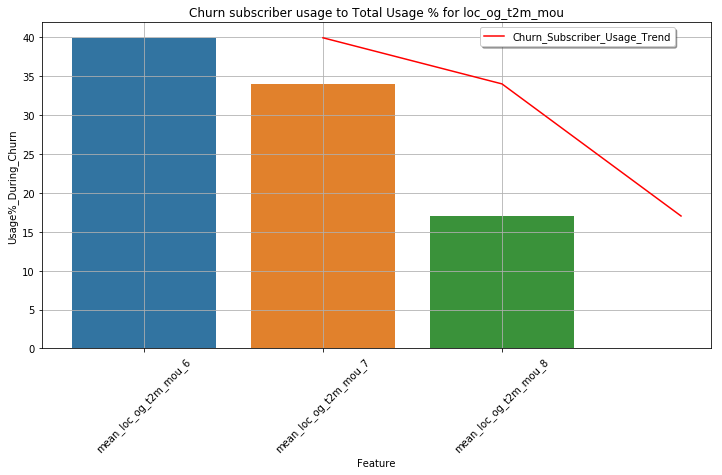

                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_loc_og_t2f_mou_6   7.335599  3.638529                33.16
2  mean_loc_og_t2f_mou_7   7.519491  3.169488                29.65
3  mean_loc_og_t2f_mou_8   7.035869  1.436529                16.96


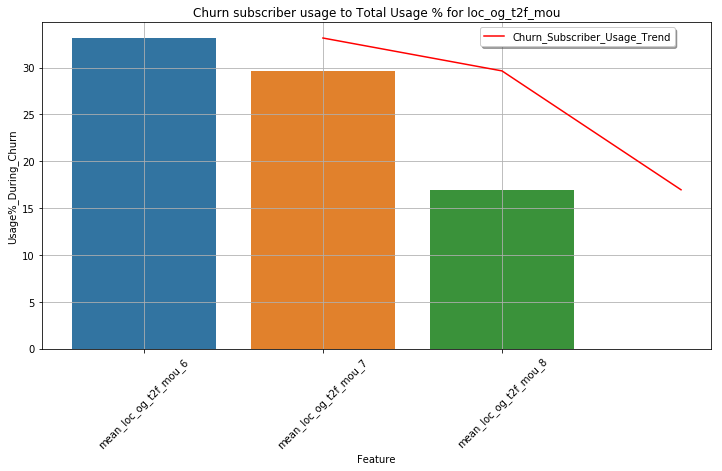

                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_loc_og_t2c_mou_6   1.552624  1.709260                52.40
2  mean_loc_og_t2c_mou_7   1.844642  2.043270                52.55
3  mean_loc_og_t2c_mou_8   1.798919  0.918561                33.80


             Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_loc_og_mou_6  292.487316  194.676952                39.96
2  mean_loc_og_mou_7  298.600130  149.431073                33.35
3  mean_loc_og_mou_8  283.163427   56.426740                16.62


                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_std_og_t2t_mou_6  176.910942  311.568457                63.78
2  mean_std_og_t2t_mou_7  195.477452  243.022827                55.42
3  mean_std_og_t2t_mou_8  181.839590   83.454979                31.46


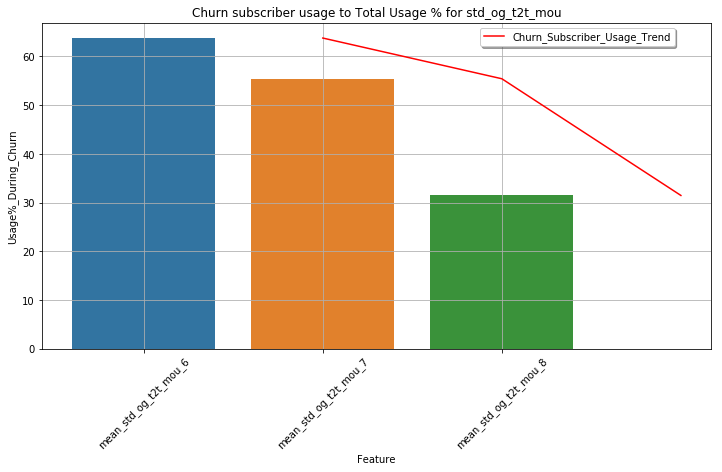

                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_std_og_t2m_mou_6  189.257808  334.005090                63.83
2  mean_std_og_t2m_mou_7  207.699928  268.039716                56.34
3  mean_std_og_t2m_mou_8  189.920509   83.539263                30.55


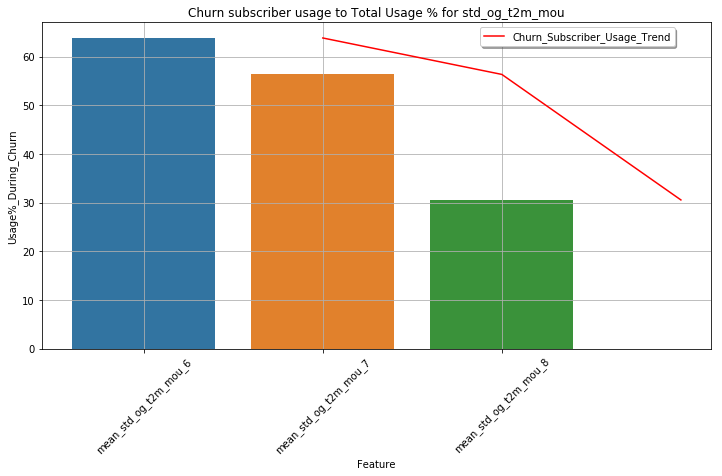

                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_std_og_t2f_mou_6   2.102660  1.162920                35.61
2  mean_std_og_t2f_mou_7   2.141403  1.046913                32.84
3  mean_std_og_t2f_mou_8   1.941105  0.383343                16.49


             Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_std_og_mou_6  368.275709  646.741111                63.72
2  mean_std_og_mou_7  405.323110  512.113813                55.82
3  mean_std_og_mou_8  373.705318  167.379481                30.93


             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_isd_og_mou_6   2.082636  3.993474                65.72
2  mean_isd_og_mou_7   2.134841  2.891938                57.53
3  mean_isd_og_mou_8   2.127265  1.114931                34.39


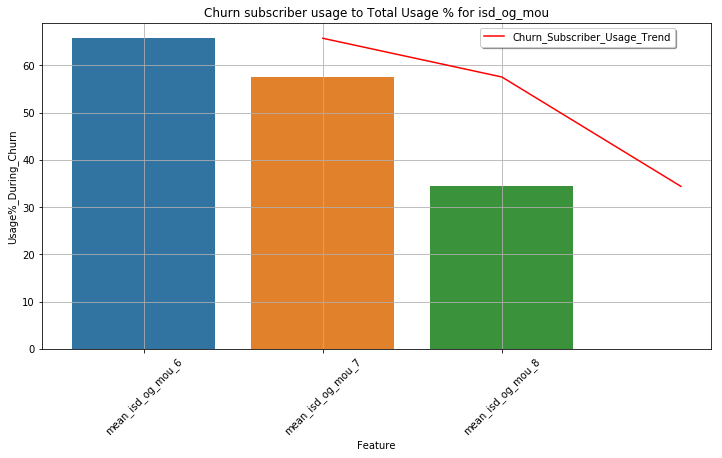

             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_spl_og_mou_6   5.795734  7.092318                55.03
2  mean_spl_og_mou_7   7.388914  7.813270                51.40
3  mean_spl_og_mou_8   7.299632  3.043858                29.43


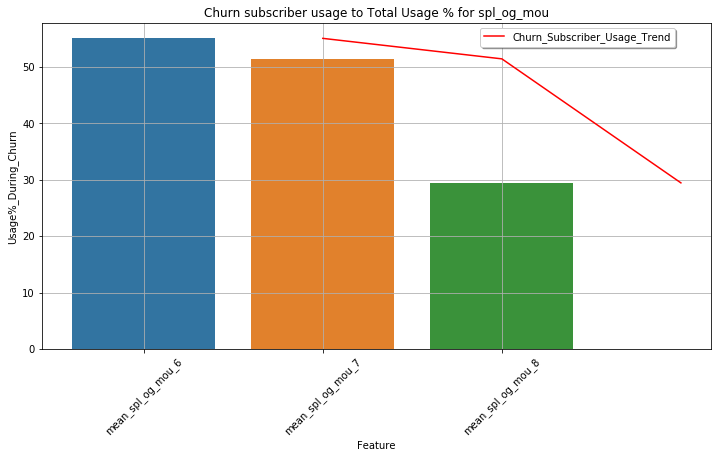

            Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_og_others_6   0.673006  0.882481                56.73
2  mean_og_others_7   0.037492  0.142875                79.21
3  mean_og_others_8   0.052457  0.122346                69.99


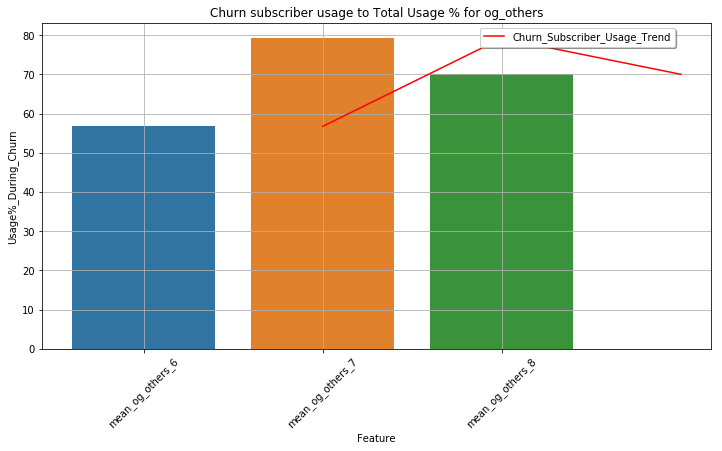

               Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_total_og_mou_6  669.324184  853.396702                56.04
2  mean_total_og_mou_7  713.493307  672.401204                48.52
3  mean_total_og_mou_8  666.356815  228.091595                25.50


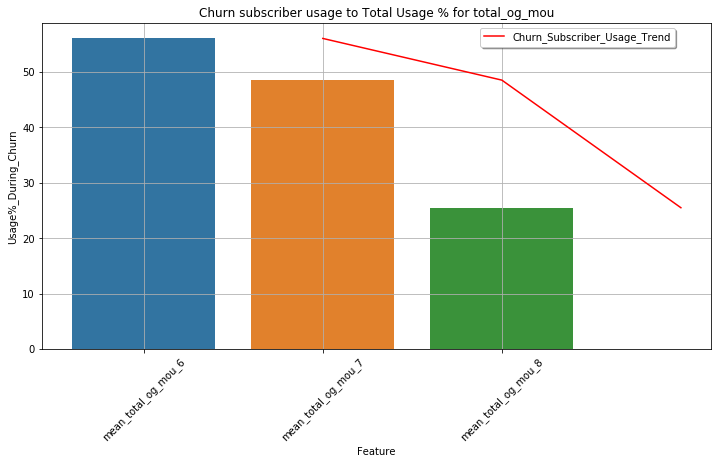

                 Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_loc_ic_t2t_mou_6  70.943867  48.411329                40.56
2  mean_loc_ic_t2t_mou_7  73.696129  38.767059                34.47
3  mean_loc_ic_t2t_mou_8  71.453281  14.459471                16.83


                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_loc_ic_t2m_mou_6  164.383205  115.581446                41.28
2  mean_loc_ic_t2m_mou_7  168.288822   91.184536                35.14
3  mean_loc_ic_t2m_mou_8  166.320172   34.882526                17.34


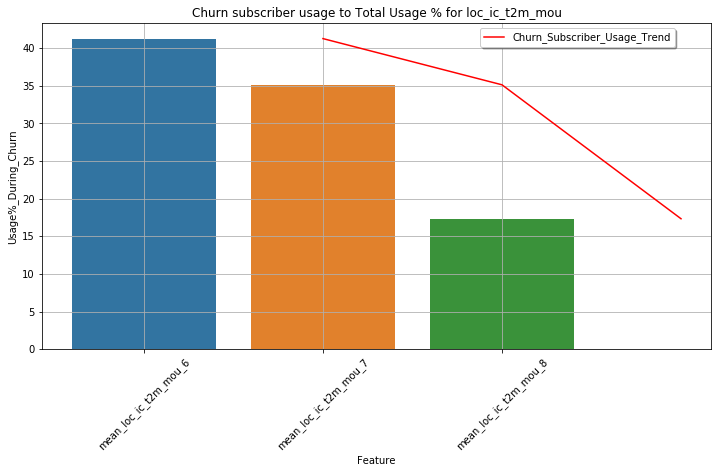

                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_loc_ic_t2f_mou_6  16.423168  7.932048                32.57
2  mean_loc_ic_t2f_mou_7  17.478314  7.526163                30.10
3  mean_loc_ic_t2f_mou_8  15.965126  2.975696                15.71


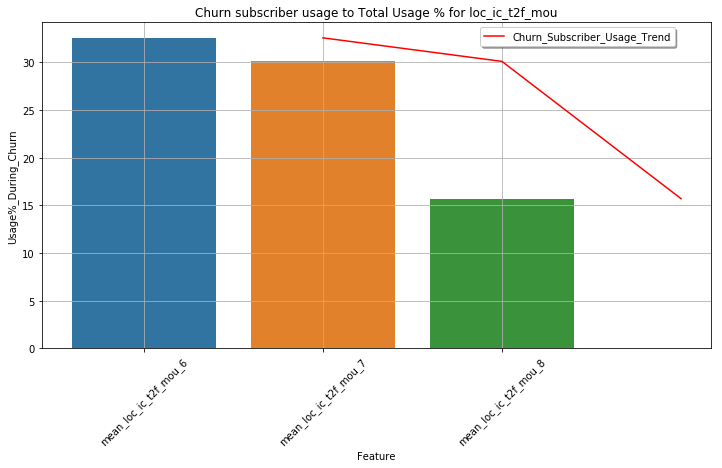

             Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_loc_ic_mou_6  251.760287  171.932803                40.58
2  mean_loc_ic_mou_7  259.473565  137.484934                34.63
3  mean_loc_ic_mou_8  253.748761   52.321651                17.09


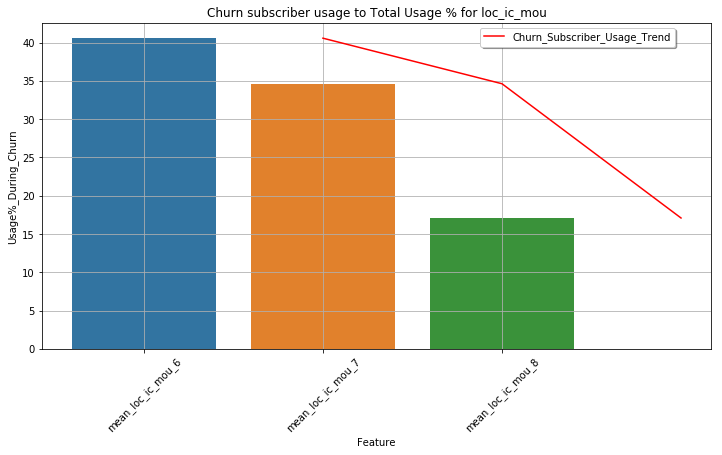

                 Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_ic_t2t_mou_6  15.739238  20.916301                57.06
2  mean_std_ic_t2t_mou_7  17.005585  15.972986                48.43
3  mean_std_ic_t2t_mou_8  16.130609   5.038893                23.80


                 Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_ic_t2m_mou_6  31.742812  34.725886                52.24
2  mean_std_ic_t2m_mou_7  34.088722  27.870927                44.98
3  mean_std_ic_t2m_mou_8  32.549258  10.594920                24.56


                 Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_std_ic_t2f_mou_6   3.021584  1.520927                33.48
2  mean_std_ic_t2f_mou_7   3.131814  1.715869                35.40
3  mean_std_ic_t2f_mou_8   2.910733  0.548927                15.87


             Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_ic_mou_6  50.507598  57.167194                53.09
2  mean_std_ic_mou_7  54.230225  45.563246                45.66
3  mean_std_ic_mou_8  51.594579  16.184270                23.88


               Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_total_ic_mou_6  314.654045  241.728993                43.45
2  mean_total_ic_mou_7  327.823473  194.325152                37.22
3  mean_total_ic_mou_8  319.203952   73.032190                18.62


             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_spl_ic_mou_6   0.067053  0.063768                48.74
2  mean_spl_ic_mou_7   0.018383  0.015069                45.05
3  mean_spl_ic_mou_8   0.029726  0.007765                20.71


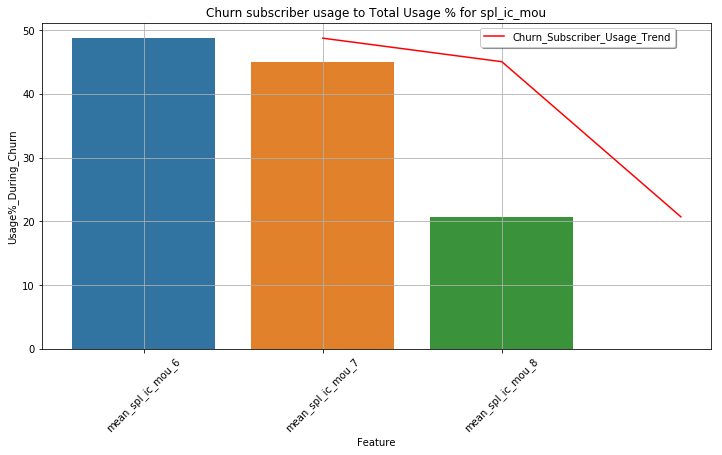

             Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_isd_ic_mou_6  11.101744  11.543709                50.98
2  mean_isd_ic_mou_7  12.538083  10.497308                45.57
3  mean_isd_ic_mou_8  12.491847   4.154374                24.96


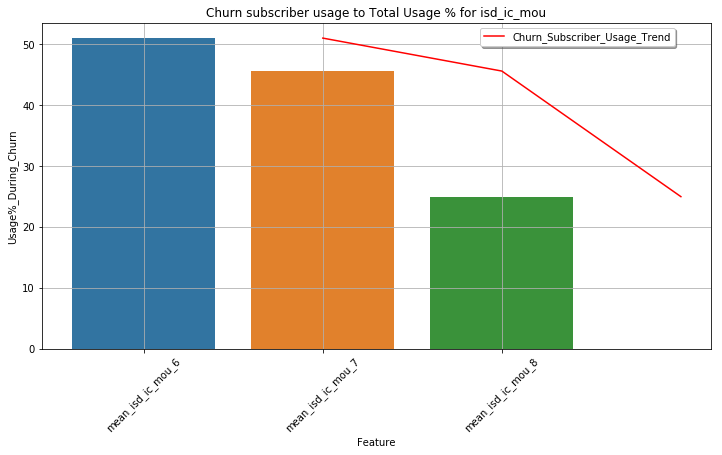

            Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_ic_others_6   1.208649  1.013159                45.60
2  mean_ic_others_7   1.555012  0.757813                32.77
3  mean_ic_others_8   1.330881  0.360612                21.32


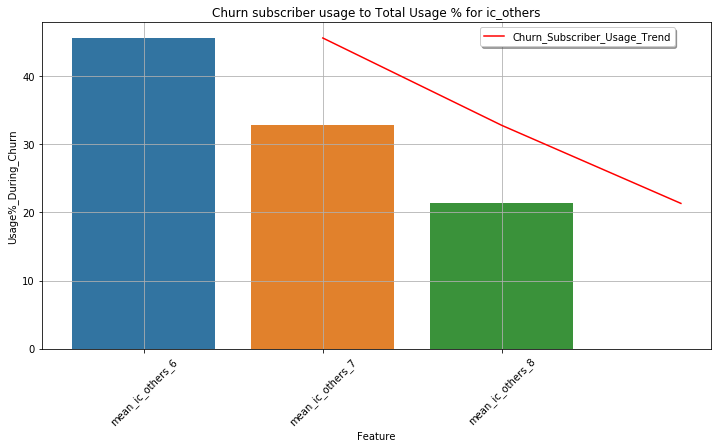

                 Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_total_rech_num_6  11.898040  14.234256                54.47
2  mean_total_rech_num_7  11.951198  11.567474                49.18
3  mean_total_rech_num_8  10.731884   5.485121                33.82


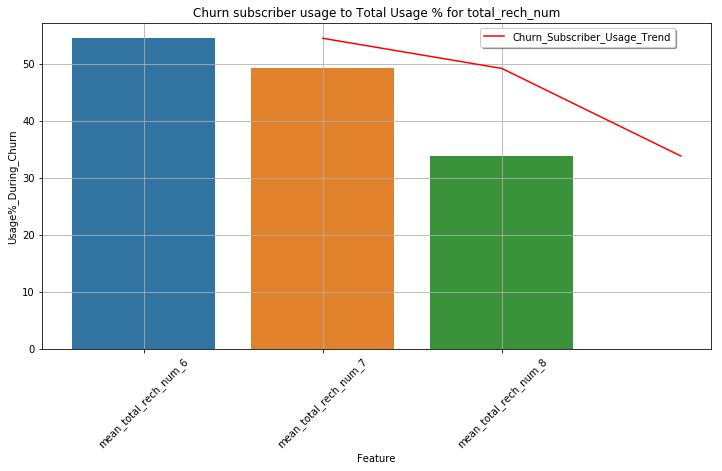

                 Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_total_rech_amt_6  687.484329  793.664706                53.58
2  mean_total_rech_amt_7  703.582450  628.133218                47.17
3  mean_total_rech_amt_8  652.272066  254.312111                28.05


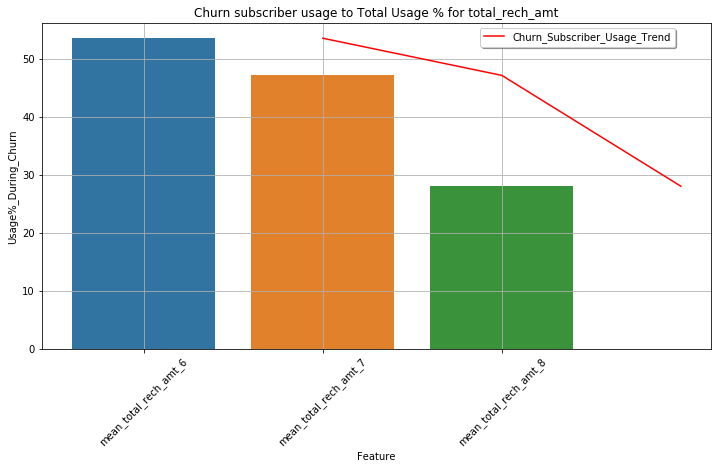

               Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_max_rech_amt_6  171.901805  167.434256                49.34
2  mean_max_rech_amt_7  177.776736  156.472664                46.81
3  mean_max_rech_amt_8  171.226439   85.157785                33.21


                   Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_last_day_rch_amt_6  104.686109  103.366090                49.68
2  mean_last_day_rch_amt_7  107.917679   80.798616                42.81
3  mean_last_day_rch_amt_8  102.025619   36.177163                26.18


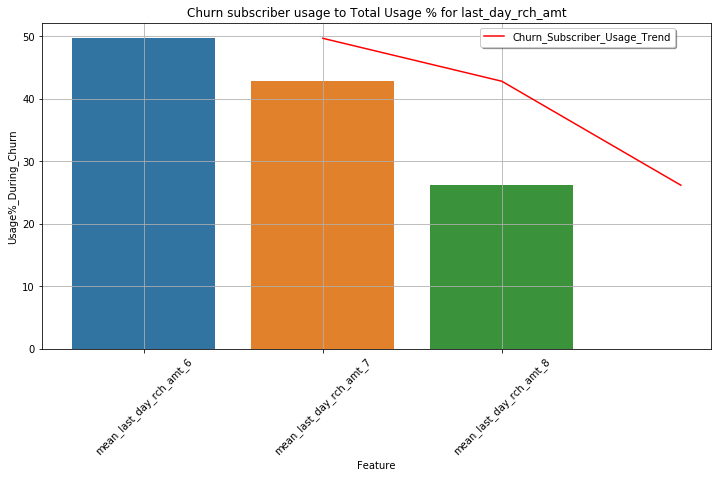

            Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_vol_2g_mb_6  80.646890  62.269166                43.57
2  mean_vol_2g_mb_7  81.141277  50.597211                38.41
3  mean_vol_2g_mb_8  74.913443  16.151678                17.74


            Feature   Not-Churn       Churn  Usage%_During_Churn
1  mean_vol_3g_mb_6  266.155294  188.023197                41.40
2  mean_vol_3g_mb_7  290.785851  161.694100                35.74
3  mean_vol_3g_mb_8  292.427606   60.412035                17.12


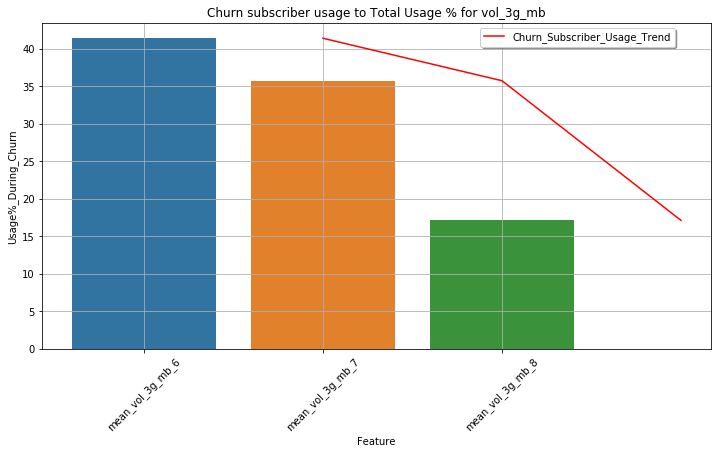

             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_monthly_2g_6   0.131529  0.063322                32.50
2  mean_monthly_2g_7   0.139725  0.053633                27.74
3  mean_monthly_2g_8   0.124331  0.017993                12.64


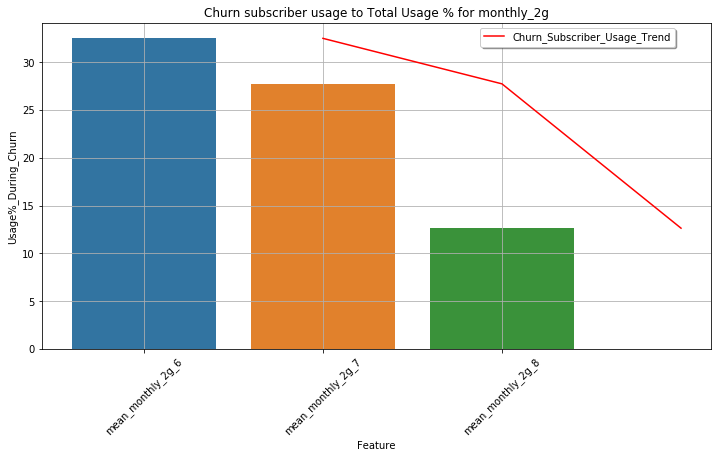

            Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_sachet_2g_6   0.507106  0.431488                45.97
2  mean_sachet_2g_7   0.604784  0.419031                40.93
3  mean_sachet_2g_8   0.651445  0.195848                23.11


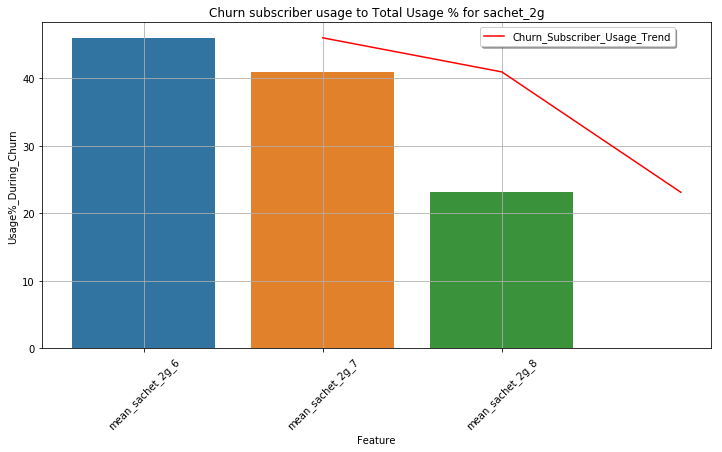

             Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_monthly_3g_6   0.178375  0.133564                42.82
2  mean_monthly_3g_7   0.194322  0.100692                34.13
3  mean_monthly_3g_8   0.188268  0.033218                15.00


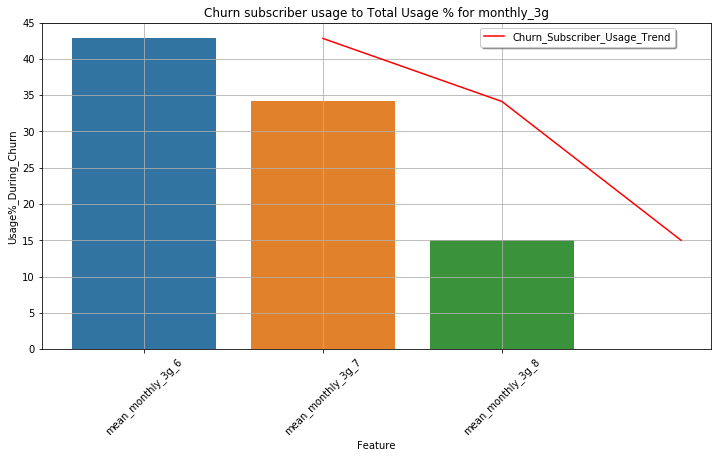

            Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_sachet_3g_6   0.139319  0.126298                47.55
2  mean_sachet_3g_7   0.151464  0.139792                48.00
3  mean_sachet_3g_8   0.150873  0.043253                22.28


               Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_rech_recency_6   3.240540   3.189965                49.61
2  mean_rech_recency_7   3.341246   5.923529                63.94
3  mean_rech_recency_8   4.002842  10.224913                71.87


           Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_rech_avg_6  76.064554  79.161270                51.00
2  mean_rech_avg_7  81.407294  70.710370                46.48
3  mean_rech_avg_8  86.673435  41.253287                32.25


                     Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_loc_og_mou_Percent_6  52.708560  29.613170                35.97
2  mean_loc_og_mou_Percent_7  53.249801  28.960253                35.23
3  mean_loc_og_mou_Percent_8  53.475177  19.059464                26.28


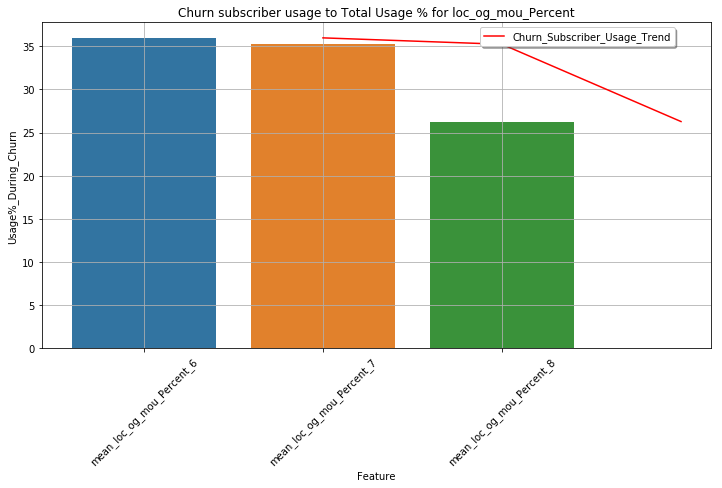

                     Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_og_mou_Percent_6  41.938430  58.297256                58.16
2  mean_std_og_mou_Percent_7  42.079739  54.036623                56.22
3  mean_std_og_mou_Percent_8  40.548743  29.220855                41.88


                     Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_spl_og_mou_Percent_6   1.622290  1.652467                50.46
2  mean_spl_og_mou_Percent_7   1.935318  2.139343                52.50
3  mean_spl_og_mou_Percent_8   2.364349  2.698097                53.30


                    Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_og_others_Percent_6   0.177869  0.192052                51.92
2  mean_og_others_Percent_7   0.010068  0.009436                48.38
3  mean_og_others_Percent_8   0.015109  0.017152                53.17


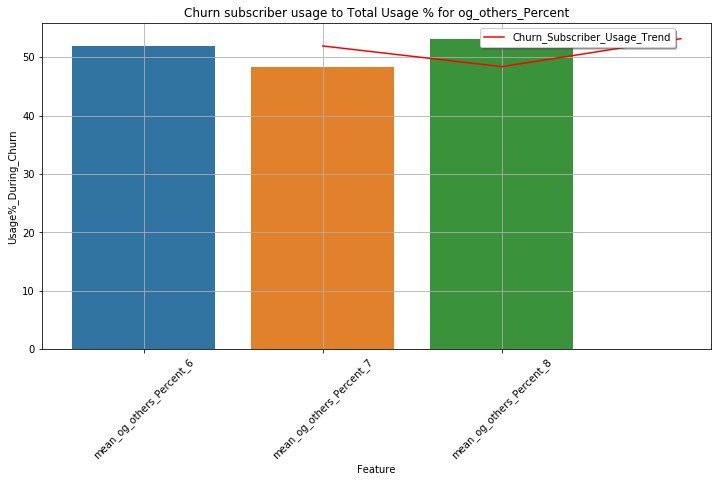

                     Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_loc_ic_mou_Percent_6  76.232645  63.287346                45.36
2  mean_loc_ic_mou_Percent_7  76.859255  60.519478                44.05
3  mean_loc_ic_mou_Percent_8  76.527610  37.483069                32.88


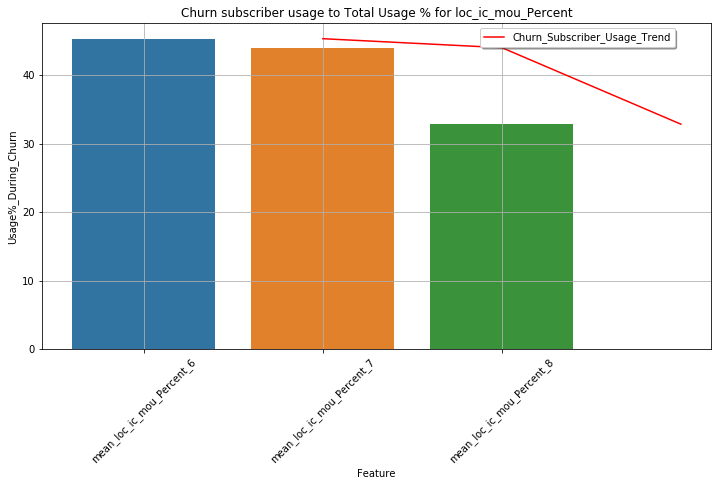

                     Feature  Not-Churn      Churn  Usage%_During_Churn
1  mean_std_ic_mou_Percent_6  17.794217  23.234218                56.63
2  mean_std_ic_mou_Percent_7  17.870203  21.189734                54.25
3  mean_std_ic_mou_Percent_8  17.391641  12.327917                41.48


                     Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_spl_ic_mou_Percent_6   0.074751  0.103464                58.06
2  mean_spl_ic_mou_Percent_7   0.026636  0.087253                76.61
3  mean_spl_ic_mou_Percent_8   0.042982  0.061021                58.67


                    Feature  Not-Churn     Churn  Usage%_During_Churn
1  mean_ic_others_Percent_6   0.421887  0.419747                49.87
2  mean_ic_others_Percent_7   0.489235  0.506163                50.85
3  mean_ic_others_Percent_8   0.451854  0.256533                36.21


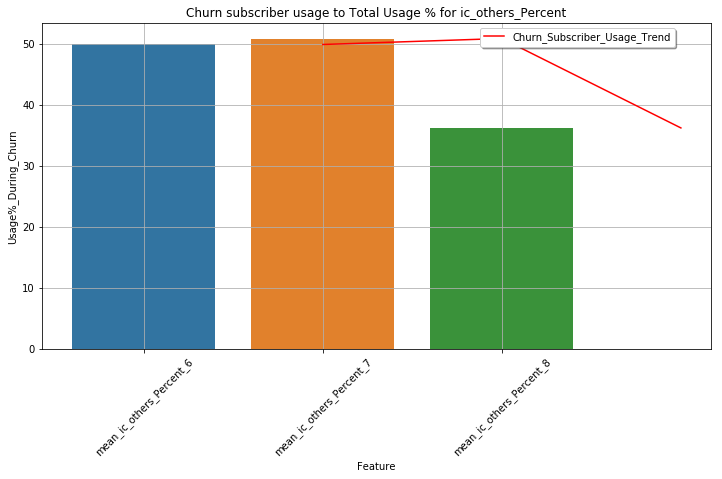

In [194]:
EDA()

### EDA Inferences:
1. ARPU, Onnet_MOU , Offnet_MOU , Local Outgoing (t2t,t2m,t2f,t2c) Monthly Usage is less in 8th month than 6th and 7th month.

2. Roam_IC_MOU,Roam_OG_MOU,Outgoing Others is not having any changes in good and decision period.

3. STD outgoing (t2t,t2m,t2f) Monthly Usage is less in 8th month than 6th and 7th month.

4. (STD,ISD,special) outgoing Monthly Usage is less in 8th month than 6th and 7th month.

5. Local Incoming (t2t,t2m) Monthly Usage is less in 8th month than 6th and 7th month.

6. STD incoming (t2t,t2m,t2f,Total) Monthly Usage is less in 8th month than 6th and 7th month.

7. Total Incoming/Outgoing Usage is less in 8th month than 6th and 7th month.

8. spl_ic_mou, isd_ic_mo, ic_others ,total_rech_num ,total_rech_amt, max_rech_amt, last_rech_amt, vol_2g_mb, vol_3g_mb, monthly_2g, Sachet_2g, Monthly_3g, Sachet_3g  is less in 8th month than 6th and 7th month.

### Outlier Treatment

In [195]:
def quantile_percentage(data):  
    quantile = pd.DataFrame(columns=['col', '10','50','85','90','95','99','99.5','100','max'])
    for col in data.columns:
        _tmp = data[col].quantile([0.1,0.5,0.85,0.9,0.95,0.99,0.995,1.0])
        quantile = quantile.append({'col': col, 
                                    '10': str(round(_tmp[0.1],2)), 
                                    '50': str(round(_tmp[0.5],2)),
                                    '85': str(round(_tmp[0.85],2)),
                                    '90': str(round(_tmp[0.9],2)),
                                    '95': str(round(_tmp[0.95],2)),
                                    '99': str(round(_tmp[0.99],2)),
                                    '99.5': str(round(_tmp[0.995],2)),
                                    '100': str(round(_tmp[1.0],2)),
                                   'max':max(data[col])}, ignore_index=True)
    return quantile

pd.set_option('display.max_rows', 500)
quantile_percentage(tele.select_dtypes([np.number]))

col            10            50            85  \
0           mobile_number  7000268865.4  7001232175.0  7002044924.8   
1                  arpu_6        270.69        495.95        861.68   
2                  arpu_7        274.46        493.78        860.35   
3                  arpu_8        134.12        452.23        839.92   
4             onnet_mou_6         10.31        125.89        589.71   
5             onnet_mou_7         10.06        125.56         611.3   
6             onnet_mou_8          2.89         99.59        523.88   
7            offnet_mou_6         52.55        282.26        732.89   
8            offnet_mou_7         53.61        282.04        753.18   
9            offnet_mou_8         19.18        241.04        679.17   
10          roam_ic_mou_6           0.0           0.0         11.74   
11          roam_ic_mou_7           0.0           0.0          4.74   
12          roam_ic_mou_8           0.0           0.0          5.48   
13          roam_og_mou_6           0.0           0.0         25.08   
14          roam_og_mou_7           0.0           0.0         12.39   
15          roam_og_mou_8           0.0           0.0         10.48   
16       loc_og_t2t_mou_6          0.78         32.61        150.52   
17       loc_og_t2t_mou_7          1.04         33.19        150.39   
18       loc_og_t2t_mou_8           0.0         28.64         141.8   
19       loc_og_t2m_mou_6          6.16        101.28        347.28   
20       loc_og_t2m_mou_7          7.59        104.36        345.49   
21       loc_og_t2m_mou_8          0.83         89.88        328.12   
22       loc_og_t2f_mou_6           0.0          0.33         11.44   
23       loc_og_t2f_mou_7           0.0           0.4         11.84   
24       loc_og_t2f_mou_8           0.0          0.16         10.82   
25       loc_og_t2c_mou_6           0.0           0.0          1.86   
26       loc_og_t2c_mou_7           0.0           0.0          2.27   
27       loc_og_t2c_mou_8           0.0           0.0           2.1   
28           loc_og_mou_6         11.64        166.33        527.18   
29           loc_og_mou_7         14.61        170.46        527.18   
30           loc_og_mou_8          2.09        148.28        501.27   
31       std_og_t2t_mou_6           0.0         12.88        413.38   
32       std_og_t2t_mou_7           0.0         13.44        447.85   
33       std_og_t2t_mou_8           0.0          5.96        349.33   
34       std_og_t2m_mou_6           0.0         37.76        414.13   
35       std_og_t2m_mou_7           0.0         37.56        442.96   
36       std_og_t2m_mou_8           0.0         23.73         355.9   
37       std_og_t2f_mou_6           0.0           0.0          0.41   
38       std_og_t2f_mou_7           0.0           0.0          0.36   
39       std_og_t2f_mou_8           0.0           0.0          0.11   
40           std_og_mou_6           0.0        126.36        886.19   
41           std_og_mou_7           0.0        132.24        932.68   
42           std_og_mou_8           0.0         73.16        804.86   
43           isd_og_mou_6           0.0           0.0           0.0   
44           isd_og_mou_7           0.0           0.0           0.0   
45           isd_og_mou_8           0.0           0.0           0.0   
46           spl_og_mou_6           0.0          0.21         10.64   
47           spl_og_mou_7           0.0          0.78         13.51   
48           spl_og_mou_8           0.0           0.5         12.29   
49            og_others_6           0.0           0.0          1.31   
50            og_others_7           0.0           0.0           0.0   
51            og_others_8           0.0           0.0           0.0   
52         total_og_mou_6         99.99        510.76       1205.47   
53         total_og_mou_7        106.06        526.13       1238.13   
54         total_og_mou_8          19.4        435.81       1141.22   
55       loc_ic_t2t_mou_6          0.98       

### Seeing the quantiles we will choose 1%ile lower quantile and 99.5%ile upper quantile and choose data accordingly

In [196]:
Q1=tele.quantile(0.01)
Q3=tele.quantile(0.995)
IQR=Q3-Q1
tele1=tele[~((tele<(Q1-1.5*IQR))|(tele>(Q3+1.5*IQR))).any(axis=1)]
tele=tele1
tele1.shape

(28565, 158)

##### Visualising Correlation matrix is pretty hard as it has so many features

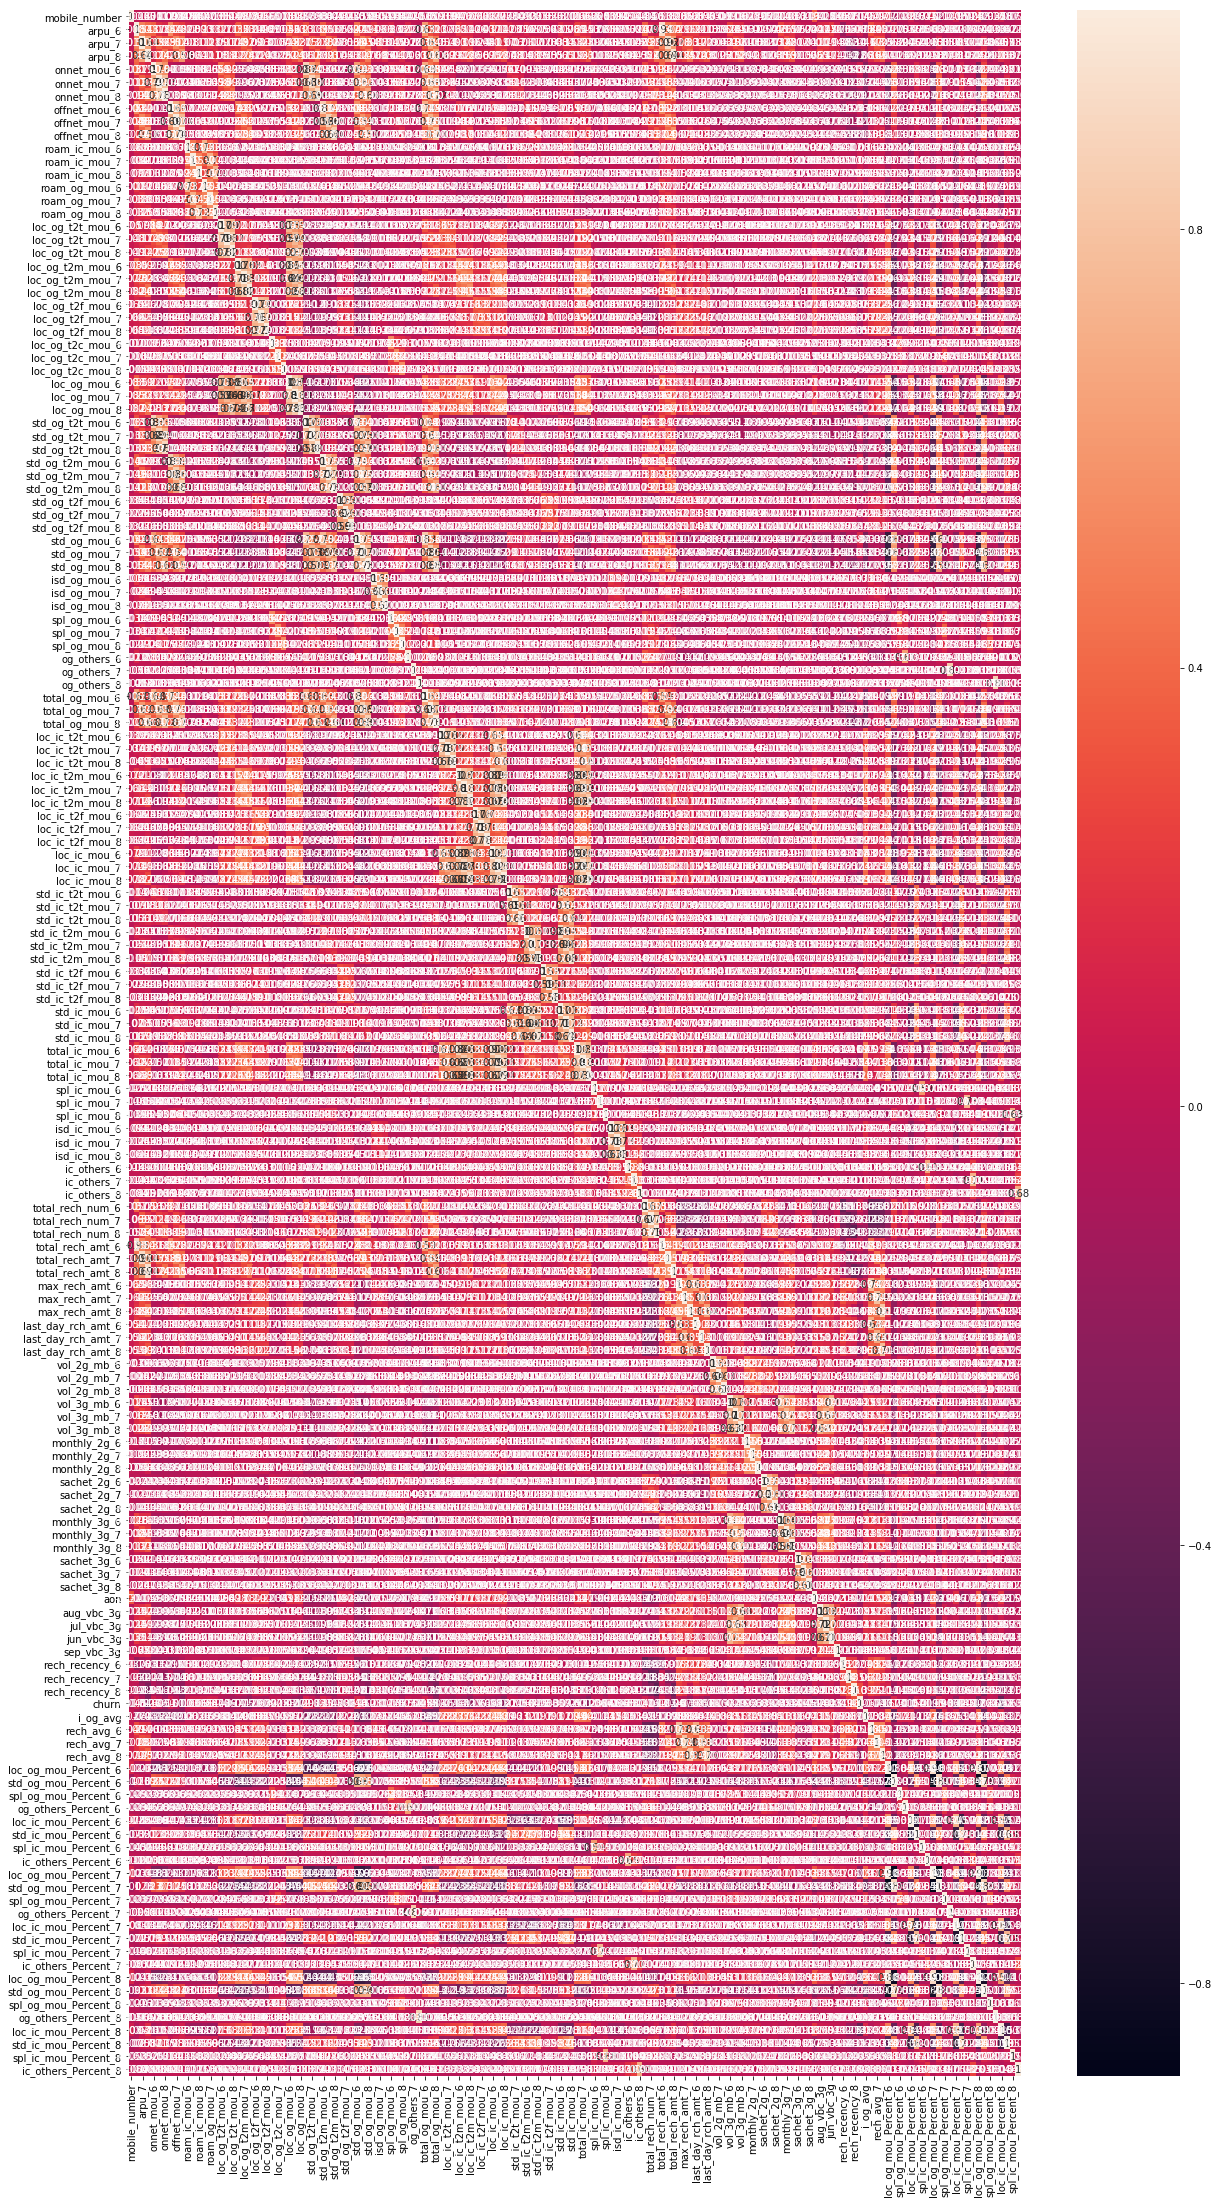

In [197]:
%matplotlib inline
plt.figure(figsize=(20,38))
sns.heatmap(tele.corr(),annot=True)

### Data split, standardisation and modelling

In [198]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn import metrics

In [199]:
X=tele.drop(['mobile_number','churn'],axis=1)
y=tele['churn'].values.reshape(-1,1)
sc=StandardScaler()
sc.fit(X)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)


##### Data modelling using Basic logistic Regression

[[5046  121]
 [ 288  258]]
Accuracy Score ==> 0.9284088920007002
AUC Score ==> 0.7245548142587044
ROC_AUC Score ==> 0.92
Not-Churn Accuracy Rate:(Specificity) ==> 0.9765821559899361
Churn Accuracy Rate:(Sensitivity) ==> 0.4725274725274725


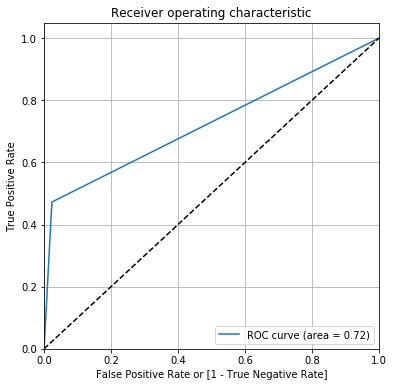

In [200]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
modelEvaluation(y_test,y_pred,lr)

##### Logistic Regression using PCA

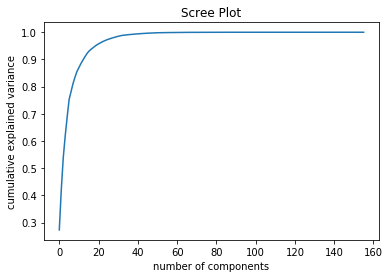

In [201]:
from sklearn.decomposition import PCA
pca=PCA(svd_solver='randomized',random_state=42)
pca.fit(X_train)
%matplotlib inline
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree Plot")
plt.show()

##### As we can see about 90% of variance is explained by 25 PCA components

In [202]:
from sklearn.decomposition import IncrementalPCA
ipca=IncrementalPCA(n_components=25)
X_train_pca=ipca.fit_transform(X_train)

In [203]:
# checking correlation matrix for this PCA components
corr=np.corrcoef(X_train_pca.T)
%matplotlib inline
plt.figure(figsize=(20,20))
sns.heatmap(corr,annot=True)
corrmat_nodiag = corr - np.diagflat(corr.diagonal())
print("max corr: {}".format(corrmat_nodiag.max()), "\n min corr: {}".format(corrmat_nodiag.min()))

max corr: 0.008911824251832111 
 min corr: -0.008652677151882435


In [204]:
# Fitting logistic regression with this PCA model.
X_test_pca=ipca.transform(X_test)
lr=LogisticRegression()
lr_pca=lr.fit(X_train_pca,y_train)
y_pred=lr_pca.predict(X_test_pca)
modelEvaluation(y_test,y_pred,lr_pca,1)

[[5097   70]
 [ 412  134]]
Accuracy Score ==> 0.9156310169788202
AUC Score ==> 0.6159368661787861
ROC_AUC Score ==> 0.89
Not-Churn Accuracy Rate:(Specificity) ==> 0.9864524869363267
Churn Accuracy Rate:(Sensitivity) ==> 0.2454212454212454


### Using Random Forest Classifier(Default)

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
rfc=RandomForestClassifier()
n_folds=5
# Create a based model
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
modelEvaluation(y_test, y_pred,rf)

[[5079   88]
 [ 324  222]]
Accuracy Score ==> 0.927883773849116
AUC Score ==> 0.69478112365668
ROC_AUC Score ==> 0.89
Not-Churn Accuracy Rate:(Specificity) ==> 0.9829688407199535
Churn Accuracy Rate:(Sensitivity) ==> 0.4065934065934066


#### Random Forest HyperParameter tuning

1. Tuning Max depth

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    8.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.7s finished


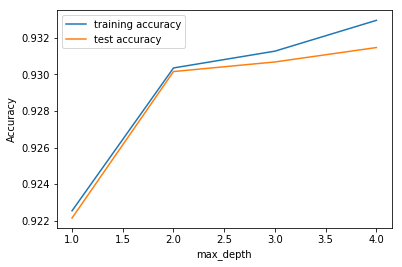

In [206]:
rfc = RandomForestClassifier()
param = {
    'max_depth': [1,2,3,4]
}
# Instantiate the grid search model
rfc = GridSearchCV(estimator = rfc,param_grid=param, 
                          cv = 3, n_jobs = -1,return_train_score=True,scoring='accuracy',verbose = 1)
rfc.fit(X_train,y_train)
scores = pd.DataFrame(rfc.cv_results_).head()
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

2. min_samples_leaf

In [207]:
rfc = RandomForestClassifier()
param = {
    'min_samples_leaf': [10,20,30, 50 , 70]
}
# Instantiate the grid search model
rfc = GridSearchCV(estimator = rfc,param_grid=param, 
                          cv = 3, n_jobs = -1,return_train_score=True,scoring='accuracy',verbose = 1)
rfc.fit(X_train,y_train)
scores = pd.DataFrame(rfc.cv_results_).head()
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.6s finished


3. min_samples_split

In [208]:
rfc = RandomForestClassifier()
param = {
    'min_samples_split': [150, 170, 200]
}
# Instantiate the grid search model
rfc = GridSearchCV(estimator = rfc,param_grid=param, 
                          cv = 3, n_jobs = -1,return_train_score=True,scoring='accuracy',verbose = 1)
rfc.fit(X_train,y_train)
scores = pd.DataFrame(rfc.cv_results_).head()
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    5.6s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    7.8s finished


4. n_estimators

In [209]:
rfc = RandomForestClassifier()
param = {
    'n_estimators': [10,30,50]
}
# Instantiate the grid search model
rfc = GridSearchCV(estimator = rfc,param_grid=param, 
                          cv = 3, n_jobs = -1,return_train_score=True,scoring='accuracy',verbose = 1)
rfc.fit(X_train,y_train)
scores = pd.DataFrame(rfc.cv_results_).head()
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    7.4s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   11.5s finished


5. max_features

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.3s finished


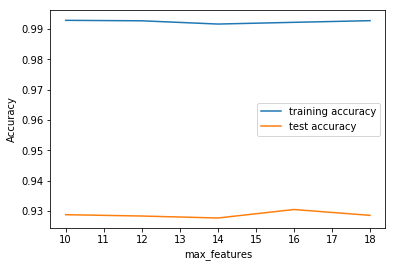

In [210]:
rfc = RandomForestClassifier()
param = {
    'max_features': [10,12,14,16,18,20]
}
# Instantiate the grid search model
rfc = GridSearchCV(estimator = rfc,param_grid=param, 
                          cv = 3, n_jobs = -1,return_train_score=True,scoring='accuracy',verbose = 1)
rfc.fit(X_train,y_train)
scores = pd.DataFrame(rfc.cv_results_).head()
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Optimal RandomForest with best parameters

[[5082   85]
 [ 313  233]]
Accuracy Score ==> 0.9303343252231752
AUC Score ==> 0.7051446875813046
ROC_AUC Score ==> 0.92
Not-Churn Accuracy Rate:(Specificity) ==> 0.9835494484226824
Churn Accuracy Rate:(Sensitivity) ==> 0.4267399267399267


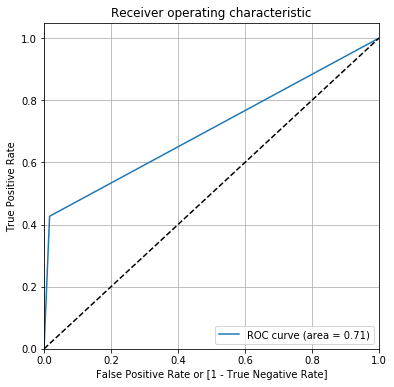

In [211]:
rf=RandomForestClassifier(max_depth=5,min_samples_leaf=50,min_samples_split=170,n_estimators=31,max_features=16)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
modelEvaluation(y_test, y_pred,rf)


### In these models, sensitivity(churn accuracy) is very less. This is due to class imbalance as number of churns are way more than non-churners. We will process this class imbalance with imblearn library.

In [212]:
print("Non-Churn Percentage:{}%".format(tele[tele['churn'] == 0].shape[0]*100/tele.shape[0]))
print("Churn Percentage:{}%".format(tele[tele['churn'] == 1].shape[0]*100/tele.shape[0]))

Non-Churn Percentage:90.34132679852966%
Churn Percentage:9.65867320147033%


In [213]:
from imblearn.over_sampling import SMOTE
print('Before SMOTE sampling :\n Shape of X_train: {} \n shape of y_train:{} \n count of y_train==1:{} \n count of y_train==0:{} '.format(X_train.shape,y_train.shape,sum(y_train==1),sum(y_train==0)))
sm=SMOTE()
X_train_sm,y_train_sm=sm.fit_sample(X_train,y_train.ravel())
print('After SMOTE sampling :\n Shape of X_train_sm: {} \n shape of y_train_sm:{} \n count of y_train_sm==1:{} \n count of y_train_sm==0:{} '.format(X_train_sm.shape,y_train_sm.shape,sum(y_train_sm==1),sum(y_train_sm==0)))

Before SMOTE sampling :
 Shape of X_train: (22852, 156) 
 shape of y_train:(22852, 1) 
 count of y_train==1:[2213] 
 count of y_train==0:[20639] 
After SMOTE sampling :
 Shape of X_train_sm: (41278, 156) 
 shape of y_train_sm:(41278,) 
 count of y_train_sm==1:20639 
 count of y_train_sm==0:20639 


#### Above you can see there is increase of pseduo churn subscribers due to SMOTE Sampling

#### Logistic Regression after SMOTE sampling

[[4555  612]
 [ 103  443]]
Accuracy Score ==> 0.8748468405391213
AUC Score ==> 0.8464556699993123
ROC_AUC Score ==> 0.92
Not-Churn Accuracy Rate:(Specificity) ==> 0.8815560286433133
Churn Accuracy Rate:(Sensitivity) ==> 0.8113553113553114


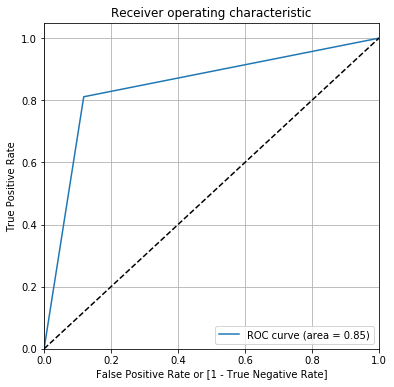

In [214]:
lr=LogisticRegression()
lr.fit(X_train_sm,y_train_sm)
y_pred=lr.predict(X_test)
modelEvaluation(y_test,y_pred,lr)

### Random forest with SMOTE

[[4727  440]
 [ 121  425]]
Accuracy Score ==> 0.9018029056537721
AUC Score ==> 0.846616240994023
ROC_AUC Score ==> 0.92
Not-Churn Accuracy Rate:(Specificity) ==> 0.9148442035997677
Churn Accuracy Rate:(Sensitivity) ==> 0.7783882783882784


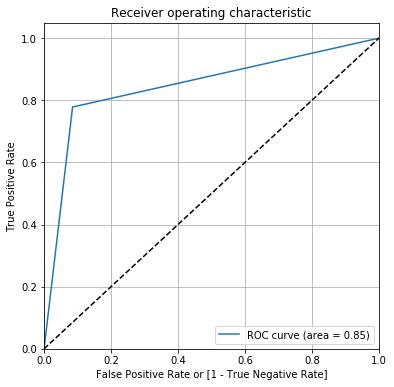

In [215]:
#using same hypertune parameters as earlier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=6,
                             min_samples_leaf=50, 
                             min_samples_split=170,
                             max_features=16,
                             n_estimators=31)
rfc.fit(X_train_sm,y_train_sm)
y_pred=rfc.predict(X_test)
modelEvaluation(y_test, y_pred,rfc)

### PCA with SMOTE

[[4232  935]
 [  91  455]]
Accuracy Score ==> 0.8204095921582356
AUC Score ==> 0.82618863299142
ROC_AUC Score ==> 0.9
Not-Churn Accuracy Rate:(Specificity) ==> 0.8190439326495065
Churn Accuracy Rate:(Sensitivity) ==> 0.8333333333333334


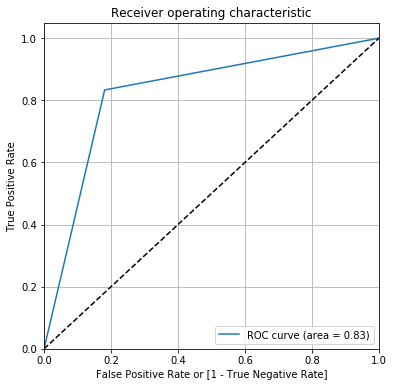

In [216]:
pca_sm=PCA(0.99)
X_train_sm_pca=pca_sm.fit_transform(X_train_sm)
X_test_pca=pca_sm.transform(X_test)
lr_pca=LogisticRegression()
model_lr=lr_pca.fit(X_train_sm_pca,y_train_sm)
y_pred=model_lr.predict(X_test_pca)
modelEvaluation(y_test,y_pred,model_lr,1)

### Decision Tree: Finding top features affecting churning rate

[[4532  635]
 [ 116  430]]
Accuracy Score ==> 0.868545422720112
AUC Score ==> 0.8323252452340897
ROC_AUC Score ==> 0.9
Not-Churn Accuracy Rate:(Specificity) ==> 0.8771047029223921
Churn Accuracy Rate:(Sensitivity) ==> 0.7875457875457875


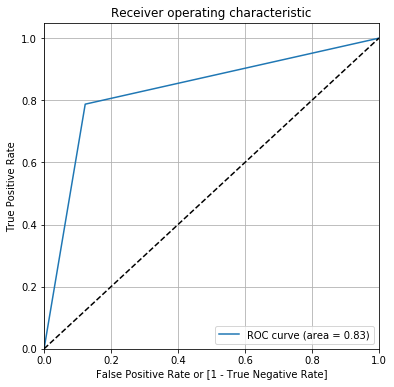

In [217]:
from sklearn.tree import DecisionTreeClassifier
dt_dflt=DecisionTreeClassifier(max_depth=5)
dt_dflt.fit(X_train_sm,y_train_sm)
y_pred=dt_dflt.predict(X_test)
modelEvaluation(y_test,y_pred,dt_dflt)

### Hypertuning Decision Tree Parameters

1. Tuning max_depth

In [218]:
from sklearn.tree import DecisionTreeClassifier
n_fol=5
dtree=DecisionTreeClassifier(criterion='gini',random_state=42)
params={'max_depth':range(1,50,5)}
gs_dt=GridSearchCV(dtree,params,cv=n_fol,scoring='accuracy',n_jobs=-1)
gs_dt.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 50, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

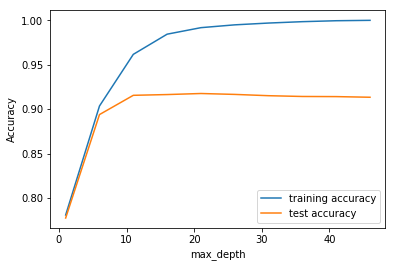

In [219]:
scores=pd.DataFrame(gs_dt.cv_results_)
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

2. Tuning min_samples_split

In [220]:
dtree=DecisionTreeClassifier(criterion='gini',random_state=100)
params={'min_samples_split':range(10,100,10)}
gs_dt=GridSearchCV(dtree,params,cv=n_fol,scoring='accuracy',n_jobs=-1)
gs_dt.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': range(10, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

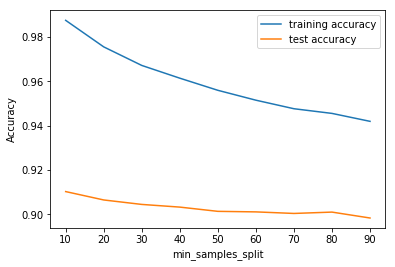

In [221]:
scores=pd.DataFrame(gs_dt.cv_results_)
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

3. Tuning min_samples_leaf

In [222]:
dtree=DecisionTreeClassifier(criterion='gini',random_state=100)
params={'min_samples_leaf':range(2,100,10)}
gs_dt=GridSearchCV(dtree,params,cv=n_fol,scoring='accuracy',n_jobs=-1)
gs_dt.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': range(2, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

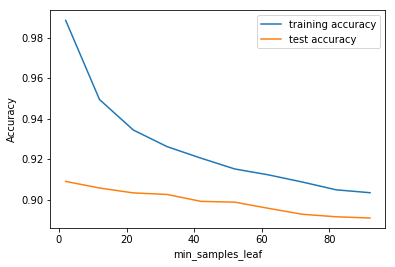

In [223]:
scores=pd.DataFrame(gs_dt.cv_results_)
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

4. max_features

In [224]:
dtree=DecisionTreeClassifier(criterion='gini',random_state=100)
params={'max_features':range(2,100,10)}
gs_dt=GridSearchCV(dtree,params,cv=n_fol,scoring='accuracy',n_jobs=-1)
gs_dt.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(2, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

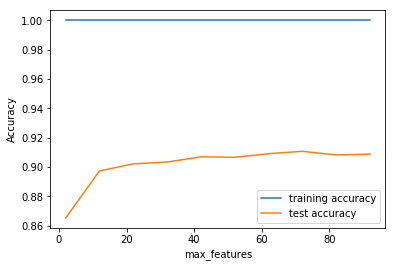

In [225]:
scores=pd.DataFrame(gs_dt.cv_results_)
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Decision Tree with Optimal Parameters

[[4454  713]
 [ 116  430]]
Accuracy Score ==> 0.8548923507789252
AUC Score ==> 0.8247773450986147
ROC_AUC Score ==> 0.87
Not-Churn Accuracy Rate:(Specificity) ==> 0.8620089026514418
Churn Accuracy Rate:(Sensitivity) ==> 0.7875457875457875


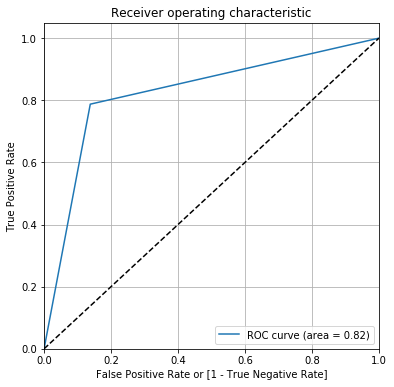

In [125]:
from sklearn.tree import DecisionTreeClassifier
dt_dflt=DecisionTreeClassifier(max_depth=4,max_features=65,min_samples_leaf=10,min_samples_split=70)
dt_dflt.fit(X_train_sm,y_train_sm)
y_pred=dt_dflt.predict(X_test)
modelEvaluation(y_test,y_pred,dt_dflt)

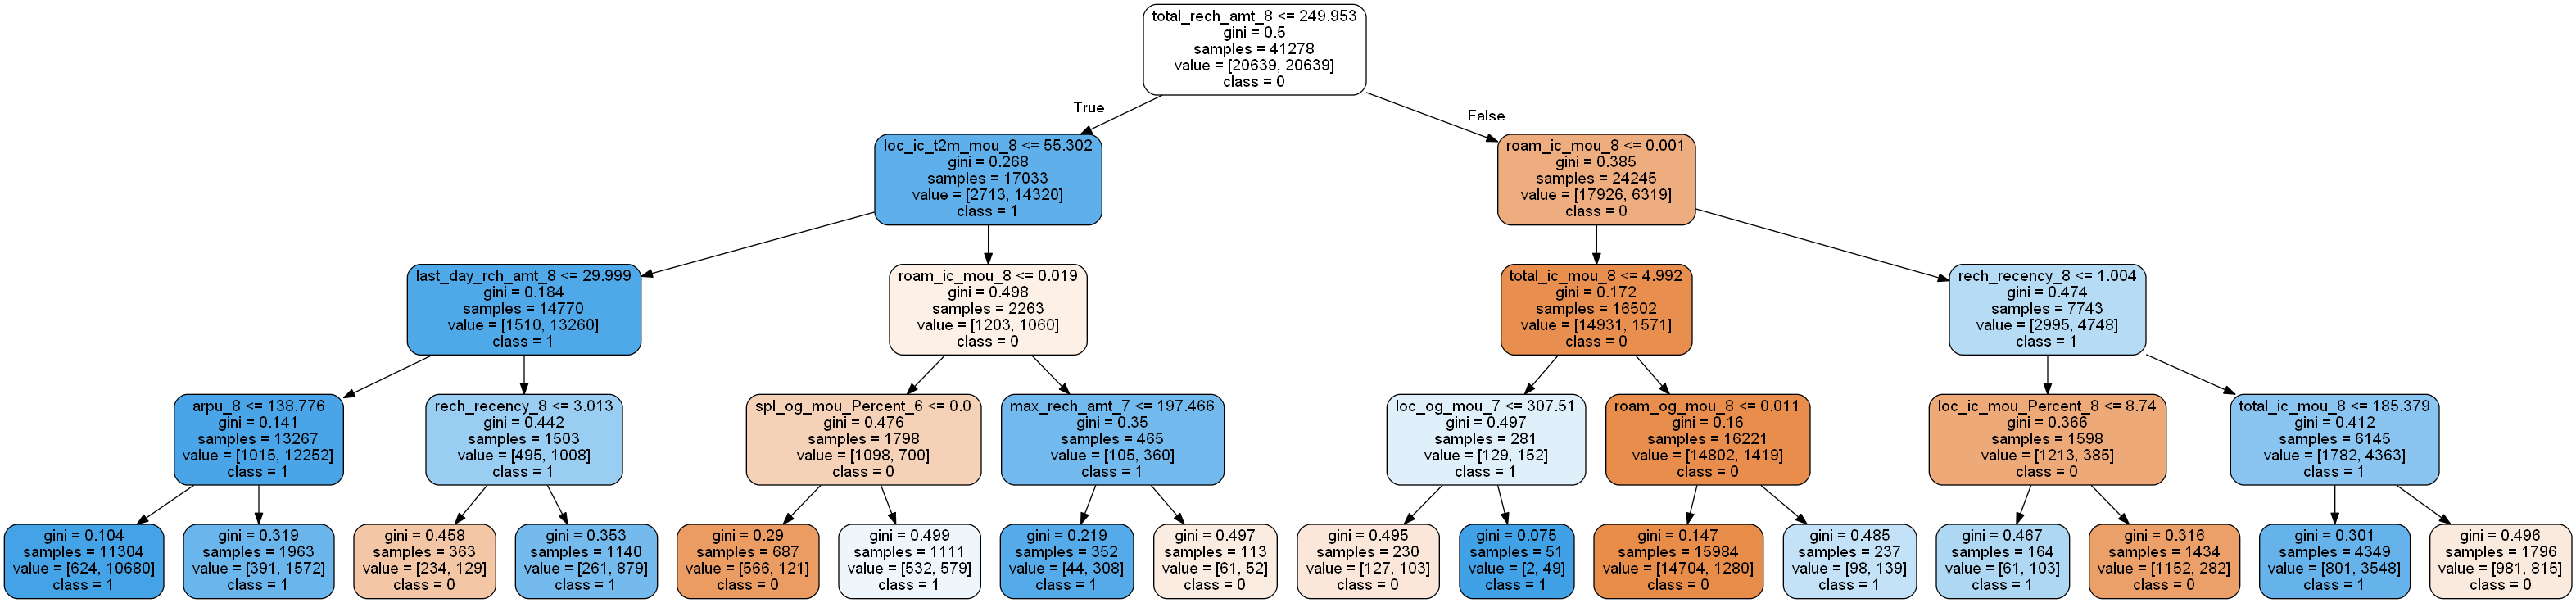

In [126]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz
features=X_train.columns
dot_data = StringIO()  
export_graphviz(dt_dflt, out_file=dot_data,
                feature_names=features, filled=True,rounded=True,class_names=['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


### Top Features determining Churning of subscribers.
1. arpu_8 & total_rech_amt_8


2. loc_ic_t2m_mou_8 , loc_ic_mou_8 and roam_ic_mou_8


3. last_day_rch_amt_8, total_og_mou_8 , total_ic_mou_8


4. roam_og_mou_8 , max_rech_amt_8, max_rech_amt_7 , loc_og_mou_7, spl_og_mou_percent_6, days_from_last_rech_8

## Summary

* SMOTE(Synthetic Minority Over Sampling Technique) with PCA(Logistic Regression) is the best model for predicting churn with churn prediction sensitivity at 83% and model accuracy at 81%. Coser to this model was Random Forest model with churn prediction sensitivity at 76% and model accuracy at 90%.

* Based on the Decision tree ,we can deduce the top features determining churning of subscribers


1. arpu_8 & total_rech_amt_8


2. loc_ic_t2m_mou_8 , loc_ic_mou_8 and roam_ic_mou_8


3. last_day_rch_amt_8, total_og_mou_8 , total_ic_mou_8


4. roam_og_mou_8 , max_rech_amt_8, max_rech_amt_7 , loc_og_mou_7, spl_og_mou_percent_6, days_from_last_rech_8

### Strategy: In below cases ,there is big probability that customer will churn, so company should entice him with dicounts and offers.
1. If total_rech_amt_8 <249 and loc_ic_t2m_mou_8<=55 and arpu_8<=138 


2. If total_rech_amt_8 >249 and roam_ic_mou_8>0.001 and days_from_last_rech_8>1 and total_ic_mou_8>185